In [1]:
import warnings

warnings.filterwarnings('ignore')

import tensorflow as tf
import pandas as pd
import nlpaug.augmenter.word as naw
import numpy as np
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Dataset/Autor_detection.csv')

# Preprocessing and EDA

In [3]:
print(df.head())

                                              Quotes      Writter name
0  Reading Kafka I sense that the elicited questi...  Alberto Manguel,
1  All animals are equal but some animals are mor...     George Orwell
2  I am old Gandalf I dont look it but I am begin...    J.R.R. Tolkien
3  How can we live without our lives How will we ...    John Steinbeck
4  I was only foolin George I dont want no ketchu...    John Steinbeck


In [4]:
df.describe()

,Quotes,Writter name
count,1571,1578
unique,1554,83
top,The coward dies a thousand deaths the brave bu...,Jane Austen
freq,2,191


In [5]:
# Conversion to lowercase
df['Quotes'] = df['Quotes'].str.lower()
df['Writter name'] = df['Writter name'].str.lower()

# Removal of NaN values
df.dropna(inplace=True)

# Removal of Duplicate entries
df.drop_duplicates(inplace=True)

# Removal of extra commas in end of author name
df['Writter name'] = df['Writter name'].str.rstrip(',')

# Removal of \r and \n from the Quotes column of the dataframe
df['Quotes'] = df['Quotes'].str.replace('\r', '')
df['Quotes'] = df['Quotes'].str.replace('\n', '')

# Removal of extra spaces from the Quotes column of the dataframe
df['Quotes'] = df['Quotes'].str.strip()

# Removal of non-ascii characters from the Writter name column
df['Writter name'] = df['Writter name'].str.encode('ascii', 'ignore').str.decode('ascii')

# Encode author names into numerical labels
label_encoder = {author: label for label, author in enumerate(df['Writter name'].unique())}
df['label'] = df['Writter name'].map(label_encoder)

In [6]:
print(df['Writter name'].value_counts())

Writter name
jane austen             187
j.r.r. tolkien          156
john steinbeck          147
charles dickens         143
william shakespeare     132
                       ... 
gnther anders             1
ernst pawel               1
kafka franz               1
hartmut m. rastalsky      1
kurt vonnegut jr.         1
Name: count, Length: 77, dtype: int64


<Axes: xlabel='Writter name'>

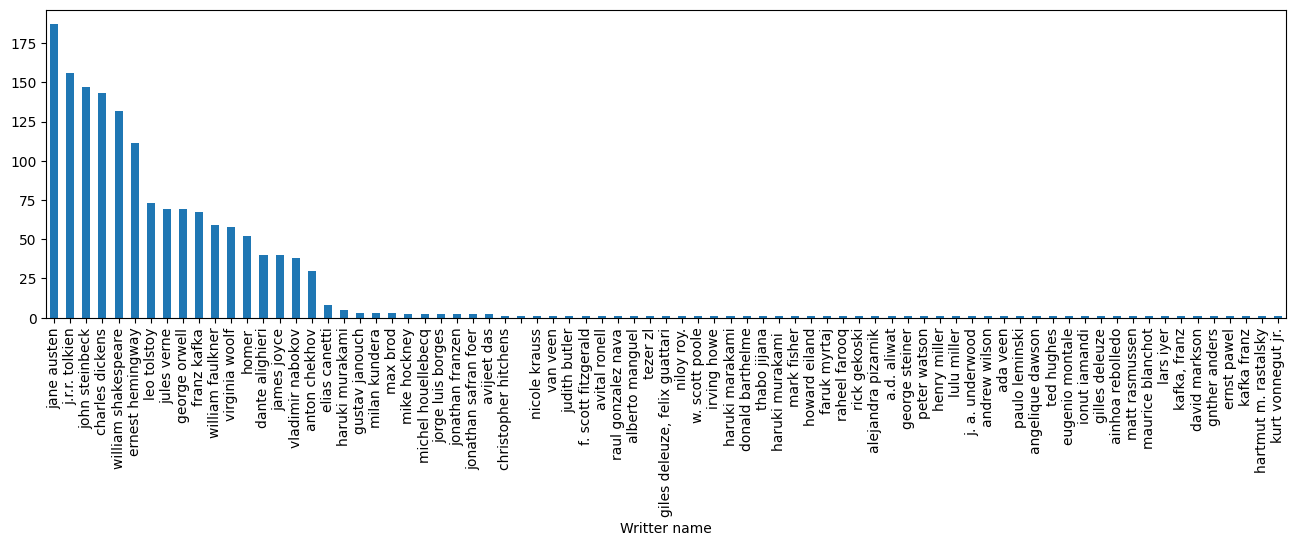

In [7]:
# plot the number of samples in each class
plt.figure(figsize=(16,4))
df['Writter name'].value_counts().plot(kind='bar')

### So we have 1554 data points. Actually during training, it was discovered that 1554 data points is not enough to generate good performance. So Data Augmentation techniques are being used to increase the number of data points.

In [8]:
for i in range(2):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_quotes = []
    for quote in df['Quotes']:
        augmented_quotes.append(str(aug.augment(quote)))
    augmented_df = pd.DataFrame({'Quotes': augmented_quotes, 'Writter name': df['Writter name'], 'label': df['label']})
    df = pd.concat([df, augmented_df], ignore_index=True)
    df['Quotes'] = df['Quotes'].str.replace('[', '')
    df['Quotes'] = df['Quotes'].str.replace(']', '')
    df['Quotes'] = df['Quotes'].str.replace("'", '')
    df.reset_index(inplace=True, drop=True)
    df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df.describe()

,label
count,6216.000000
mean,10.228443
std,10.497455
min,0.000000
25%,4.000000
50%,8.000000
75%,13.000000
max,76.000000


In [10]:
df

,Quotes,Writter name,label
0,cunto la hemos hecho sufrir por tu forma de se...,franz kafka,16
1,the music of the pearl was pipe with victory i...,john steinbeck,3
2,melvil dewey dell rise heaving to her feet she...,william faulkner,17
3,love all trust a few do wrong to none,william shakespeare,10
4,mr darcy soon drew the attention of the room b...,jane austen,5
...,...,...,...
6211,man is the only real foe we experience move ou...,george orwell,1
6212,at that place live nothing in the world so irr...,charles dickens,8
6213,feeling herself suddenly shriveled aged breast...,virginia woolf,20
6214,whole the missy in the earthly concern were di...,leo tolstoy,13


# Model 1 : BERT

In [11]:
num_classes = len(label_encoder)

train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_data, valid_data = train_test_split(train_data, test_size=0.1, stratify=train_data['label'], random_state=42)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(list(train_data['Quotes']), truncation=True, padding=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(list(test_data['Quotes']), truncation=True, padding=True, max_length=128, return_tensors='tf')
valid_encodings = tokenizer(list(valid_data['Quotes']), truncation=True, padding=True, max_length=128, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), to_categorical(train_data['label'], num_classes=num_classes)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), to_categorical(test_data['label'], num_classes=num_classes)))
valid_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encodings), to_categorical(valid_data['label'], num_classes=num_classes)))

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=10, batch_size=16, validation_data=valid_dataset.shuffle(1000).batch(16))

results = model.evaluate(test_dataset.batch(16))
print("The accuracy on the test set is:", results[1] * 100)


2024-01-09 23:36:32.231234: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-09 23:36:32.231256: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-09 23:36:32.231260: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-09 23:36:32.231295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-09 23:36:32.231314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initializ

Epoch 1/10


2024-01-09 23:36:46.289330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-01-09 23:36:47.642130: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


280/280 [==============================] - 233s 757ms/step - loss: 3.1426 - accuracy: 0.1911 - val_loss: 2.5587 - val_accuracy: 0.3273
Epoch 2/10
280/280 [==============================] - 194s 689ms/step - loss: 2.2090 - accuracy: 0.4222 - val_loss: 1.8454 - val_accuracy: 0.5442
Epoch 3/10
280/280 [==============================] - 195s 694ms/step - loss: 1.3979 - accuracy: 0.6457 - val_loss: 1.2168 - val_accuracy: 0.6888
Epoch 4/10
280/280 [==============================] - 192s 684ms/step - loss: 0.8004 - accuracy: 0.8230 - val_loss: 0.8056 - val_accuracy: 0.8173
Epoch 5/10
280/280 [==============================] - 194s 691ms/step - loss: 0.4889 - accuracy: 0.9012 - val_loss: 0.6059 - val_accuracy: 0.8554
Epoch 6/10
280/280 [==============================] - 194s 693ms/step - loss: 0.3302 - accuracy: 0.9334 - val_loss: 0.5058 - val_accuracy: 0.8916
Epoch 7/10
280/280 [==============================] - 193s 688ms/step - loss: 0.2523 - accuracy: 0.9511 - val_loss: 0.5055 - val_accura

# Model 2 : Word2Vec + RNN(LSTM)

In [12]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Quotes'], df['label'], test_size=0.2, random_state=42
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

train_texts = [text.split() for text in train_texts]
test_texts = [text.split() for text in test_texts]
val_texts = [text.split() for text in val_texts]

word2vec_model = Word2Vec(sentences=train_texts, vector_size=100, window=5, min_count=1, workers=4)

max_len = 100
train_sequences = [[word2vec_model.wv[word] for word in text if word in word2vec_model.wv.key_to_index] for text in train_texts]
test_sequences = [[word2vec_model.wv[word] for word in text if word in word2vec_model.wv.key_to_index] for text in test_texts]
val_sequences = [[word2vec_model.wv[word] for word in text if word in word2vec_model.wv.key_to_index] for text in val_texts]

train_sequences_pad = pad_sequences(train_sequences, maxlen=max_len, dtype='float32')
test_sequences_pad = pad_sequences(test_sequences, maxlen=max_len, dtype='float32')
val_sequences_pad = pad_sequences(val_sequences, maxlen=max_len, dtype='float32')

model = Sequential()
model.add(Bidirectional(LSTM(228, return_sequences=True, input_shape=(max_len, 100))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(250, return_sequences=True)))
model.add(Dropout(0.3)) 
model.add(Bidirectional(LSTM(270, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(300))) 
model.add(Dropout(0.3)) 
model.add(Dense(len(df['Writter name'].unique()), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_sequences_pad, train_labels, epochs=100, batch_size=64, validation_data=(val_sequences_pad, val_labels))

test_loss, test_accuracy = model.evaluate(test_sequences_pad, test_labels)
print(f"Test Accuracy: {test_accuracy * 100}")

Epoch 1/100
63/63 [==============================] - 37s 413ms/step - loss: 3.0705 - accuracy: 0.1179 - val_loss: 2.9325 - val_accuracy: 0.1337
Epoch 2/100
63/63 [==============================] - 16s 256ms/step - loss: 2.8655 - accuracy: 0.1260 - val_loss: 2.8372 - val_accuracy: 0.1668
Epoch 3/100
63/63 [==============================] - 16s 260ms/step - loss: 2.7832 - accuracy: 0.1531 - val_loss: 2.7922 - val_accuracy: 0.1769
Epoch 4/100
63/63 [==============================] - 16s 250ms/step - loss: 2.7498 - accuracy: 0.1494 - val_loss: 2.7747 - val_accuracy: 0.1869
Epoch 5/100
63/63 [==============================] - 17s 263ms/step - loss: 2.7004 - accuracy: 0.1634 - val_loss: 2.7416 - val_accuracy: 0.1779
Epoch 6/100
63/63 [==============================] - 16s 260ms/step - loss: 2.6804 - accuracy: 0.1655 - val_loss: 2.7421 - val_accuracy: 0.1518
Epoch 7/100
63/63 [==============================] - 16s 253ms/step - loss: 2.6499 - accuracy: 0.1634 - val_loss: 2.7728 - val_accuracy:

# Model 3 : TF-IDF + Softmax Regression

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['Quotes'], df['label'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_tfidf.toarray(), y_train, validation_data=(X_val_tfidf.toarray(), y_val), epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test)
print(f"Test Accuracy: {accuracy * 100}")

Epoch 1/10
125/125 [==============================] - 3s 20ms/step - loss: 3.4966 - accuracy: 0.1026 - val_loss: 2.9673 - val_accuracy: 0.1276
Epoch 2/10
125/125 [==============================] - 1s 11ms/step - loss: 2.8166 - accuracy: 0.1637 - val_loss: 2.7052 - val_accuracy: 0.3136
Epoch 3/10
125/125 [==============================] - 2s 13ms/step - loss: 2.3586 - accuracy: 0.3515 - val_loss: 2.2311 - val_accuracy: 0.4533
Epoch 4/10
125/125 [==============================] - 1s 11ms/step - loss: 1.6606 - accuracy: 0.5831 - val_loss: 1.6559 - val_accuracy: 0.6432
Epoch 5/10
125/125 [==============================] - 1s 10ms/step - loss: 1.0278 - accuracy: 0.7795 - val_loss: 1.2236 - val_accuracy: 0.7658
Epoch 6/10
125/125 [==============================] - 1s 10ms/step - loss: 0.6216 - accuracy: 0.8846 - val_loss: 0.9526 - val_accuracy: 0.8161
Epoch 7/10
125/125 [==============================] - 1s 10ms/step - loss: 0.4033 - accuracy: 0.9324 - val_loss: 0.8034 - val_accuracy: 0.8362